# Moving Company Exploratory Data Analysis

Imports the Google Calendar information from a moving company and describes relevant data.

We need the Python library _icalendar_ to parse the Google Calendar.

In [1]:
from icalendar import Calendar, Event

Let's create a Python dictionary to hold the data from the moving jobs

In [2]:
jobs = {}
i = 0

The text fields (summary and description) have newlines (/n) and $. We need a method for Python to correctly interpret these.

## I'm not sure I understand the notes in the DESCRIPTION field

It seems like it is some shorthand on how many hours the job took, what the hourly rate will be, how many movers are needed, etc. It's going to be difficult to parse this, but we'll take a stab at it with some regular expressions.

In some cases, I think they are listing the hourly rate. In other cases, I think they are listing the total charge. I need some sort of client decision on how to tell which is which. Of course, there are some cases where they have more than 5 movers so that might explain the high hourly rates (5 movers x \$50/hr = \$250/hr)

In [3]:
import re

'''
Extract the hourly rate
This should be in the description after the dollar sign.
However, this should be checked with the client.
I think sometimes the number is the hourly rate and other times it is the total charge.
So use a regular expression
'''
def extractRate(text):
    
    rate = re.findall(r'[\$]{1}\d+\.?\d{0,2}',text)
    if len(rate) > 0:  # Only return first dollar amount found
        rate = float(rate[0][1:])   # Strip dollar sign and return decimal only
    else:
        rate = None
    return rate

Extract the email address of the customer

In [4]:
'''
Extract the email address of the customer
'''
def extractEmail(text):
    
    # Regular expression to match email addresses
    email = re.findall(r'[\w+\.]*\w+@[\w.-]+|\{(?:\w+, *)+\w+\}@[\w.-]+',text.replace('\\n', ' '))
    if len(email) > 0:
        email = email[0]
    else:
        email = None
        
    return email


Search the _summary_ field for the word cancelled. Keep track of cancelled jobs.

In [5]:
'''
Determine if customer has cancelled the appointment
'''
def hasCancelled(text):
    
    if 'cancelled' not in text.lower():
        return False
    else:
        return True


Extract the zip code

In [6]:
def extractZipCode(text):
    
    if text == None:
        return None
    
    '''
    This regex gets a tuple of full zip and 4 digits after the - 
    '''
    zips = re.findall(r'.*(\d{5}(\-\d{4})?)$', text)
    if len(zips) > 0:
        return zips[0][0]
    else:
        return None

### It looks like after September 2015, they started using a form to fill out the description

The form has customer name, phone, email, booked by, origin, destination, and all other useful fields.

For example, 
['DARNELL\\, ALAN',
 'NAME: Tian Hui Zhang ',
 'PHONE: 858-997-7729',
 'EMAIL: zzztianhui@gmail.com',
 'Booked BY: Frank on 09/21/2015',
 '',
 'ORIGIN: 7655 Palmilla Dr \#7675\\, San Diego\\, CA 92122',
 'DESTINATION:3833 Nobel Drive\\, San Diego\\, CA 92122 ',
 '',
 'SIZE: 1 Bedroom',
 'SERVICE: moving furniture and Full Pack',
 'CREW: 2 movers ',
 'TRUCKS: 1',
 'MATERIALS: standard Full Pack',
 'ESTIMATE:N/A',
 'RATE: \$88/hour - cash\\, $98/hour - card',
 'NOT TO EXCEED:N/A',
 '',
 'NOTES: Full Pack']

In [7]:
def parseDescription(text):
    
    notes = {}
    notes['ORIGIN'] = None
    notes['ORIGIN TYPE'] = None
    notes['DESTINATION'] = None
    notes['DESTINATION TYPE'] = None
    notes['SIZE'] = None
    notes['CREW'] = None
    notes['TRUCKS'] = None
    notes['RATE'] = None
    notes['PHONE'] = None
    notes['NAME'] = None

    for item in text.split('\\n'):

        if item[0:(len('ORIGIN:'))].upper() == 'ORIGIN:':
            notes['ORIGIN'] = item[len('ORIGIN:'):].strip()
            
        if item[0:(len('Pick up Address:'))].upper() == 'PICK UP ADDRESS:':
            notes['ORIGIN'] = item[len('Pick up Address:'):].strip()
            
        if item[0:(len('Pick up Address Type:'))].upper() == 'PICK UP ADDRESS TYPE:':
            notes['ORIGIN TYPE'] = item[len('Pick up Address Type:'):].strip()    

        if item[0:(len('DESTINATION:'))].upper() == 'DESTINATION:':
            notes['DESTINATION'] =  item[len('DESTINATION:'):].strip()
            
        if item[0:(len('Drop off Address Type:'))].upper() == 'DROP OFF ADDRESS TYPE:':
            notes['DESTINATION TYPE'] = item[len('Drop off Address Type:'):].strip()    

        if item[0:(len('Drop off  Address:'))].upper() == 'DROP OFF  ADDRESS:':
            notes['DESTINATION'] = item[len('Drop off  Address:'):].strip()
            
        if item[0:(len('SIZE:'))].upper() == 'SIZE:':
            notes['SIZE'] = item[len('SIZE:'):].strip()

        if item[0:(len('CREW:'))].upper() == 'CREW:':
            notes['CREW'] = item[len('CREW:'):].strip()
            
        if item[0:(len('Crew Size:'))].upper() == 'CREW SIZE:':
            notes['CREW'] = item[len('Crew Size:'):].strip()

        if item[0:(len('TRUCKS:'))].upper() == 'TRUCKS:':
            notes['TRUCKS'] = item[len('TRUCKS:'):].strip()

        if item[0:(len('RATE:'))].upper() == 'RATE:':
            notes['RATE'] = extractRate(item[len('RATE:'):].strip())
            
        if item[0:(len('Rate and Fees:'))].upper() == 'RATE AND FEES:':
            notes['RATE'] = extractRate(item[len('Rate and Fees:'):].strip())

        if item[0:(len('PHONE:'))].upper() == 'PHONE:':
            notes['PHONE'] = item[len('PHONE:'):].strip()

        if item[0:(len('NAME:'))].upper() == 'NAME:':
            notes['NAME'] = item[len('NAME:'):].strip()
            
        notes['ORIGIN ZIP'] = extractZipCode(notes['ORIGIN'])
        notes['DESTINATION ZIP'] = extractZipCode(notes['DESTINATION'])
            
    return notes

In [8]:
def raw(text):
    return text

The _icalendar_ library parses the calendar. For every _event_ in the calendar, we check to see which fields are present.

In [9]:
def parseKeys(component):
    
      
    if component.has_key('DTSTART'):
            DTSTART = component.get('DTSTART').to_ical()
    else:
        DTSTART = None

    if component.has_key('DTEND'):
        DTEND = component.get('DTEND').to_ical()
    else:
        DTEND = None

    if component.has_key('RRULE'):
        RRULE = component.get('RRULE').to_ical()
    else:
        RRULE = None

    if component.has_key('DTSTAMP'):
        DTSTAMP = component.get('DTSTAMP').to_ical()
    else:
        DTSTAMP = None

    if component.has_key('UID'):
        UID = component.get('UID').to_ical()
    else:
        UID = None

    if component.has_key('CREATED'):
        CREATED = component.get('CREATED').to_ical()
    else:
        CREATED = None

    if component.has_key('DESCRIPTION'):
        DESCRIPTION = raw(component.get('DESCRIPTION').to_ical())
        EMAIL = extractEmail(DESCRIPTION)
        parsed = parseDescription(DESCRIPTION)
    else:
        DESCRIPTION = None
        EMAIL = None
        parsed = parseDescription('')

    if component.has_key('LAST-MODIFIED'):
        LASTMODIFIED = component.get('LAST-MODIFIED').to_ical()
    else:
        LASTMODIFIED = None

    if component.has_key('LOCATION'):
        LOCATION = component.get('LOCATION').to_ical()
    else:
        LOCATION = None

    if component.has_key('SEQUENCE'):
        SEQUENCE = component.get('SEQUENCE').to_ical()
    else:
        SEQUENCE = None

    if component.has_key('SUMMARY'):
        SUMMARY = raw(component.get('SUMMARY').to_ical())
        CANCELLED = hasCancelled(SUMMARY)
    else:
        SUMMARY = None
        CANCELLED = None

    if component.has_key('TRANSP'):
        TRANSP = component.get('TRANSP').to_ical()
    else:
        TRANSP = None


    return [DTSTART,
            DTEND,
            RRULE,
            DTSTAMP,
            UID,
            CREATED,
            DESCRIPTION,
            parsed['ORIGIN'],
            parsed['ORIGIN TYPE'],
            parsed['ORIGIN ZIP'],
            parsed['DESTINATION'],
            parsed['DESTINATION TYPE'],
            parsed['DESTINATION ZIP'],
            parsed['SIZE'],
            parsed['CREW'],
            parsed['TRUCKS'],
            parsed['RATE'],
            parsed['NAME'],
            parsed['PHONE'],
            EMAIL,
            LASTMODIFIED,
            LOCATION,
            SEQUENCE,
            SUMMARY,
            CANCELLED,
            TRANSP]

Now go through the file and parse the moving jobs into the dictionary

In [10]:
fileName = 'vectormovingsd@gmail.com.ics'

with open(fileName,'rb') as fp:
    gcal = Calendar.from_ical(fp.read())
    for component in gcal.walk():
    
        if component.name == 'VEVENT':
         
            jobs[i] = parseKeys(component)

            i += 1
    
fp.close()

Let's put the jobs into Pandas

In [11]:
import pandas as pd

In [12]:
dfJobs = pd.DataFrame.from_dict(jobs, orient='index')
dfJobs.columns = ['DTSTART',
                  'DTEND',
                  'RRULE',
                  'DTSTAMP',
                  'UID',
                  'CREATED',
                  'DESCRIPTION',
                  'ORIGIN',
                  'ORIGIN TYPE',
                  'ORIGIN ZIP CODE',
                  'DESTINATION',
                  'DESTINATION TYPE',
                  'DESTINATION ZIP CODE',
                  'SIZE',
                  'CREW',
                  'TRUCKS',
                  'RATE',
                  'CUSTOMER NAME',
                  'CUSTOMER PHONE',
                  'CUSTOMER EMAIL',
                  'LAST MODIFIED',
                  'LOCATION',
                  'SEQUENCE',
                  'SUMMARY',
                  'CANCELLED',
                  'TRANSP']

In [13]:
del jobs   # Free up memory

Let's convert the time/date stamps to correct format.

In [14]:
dfJobs['DTSTART'] = pd.to_datetime(dfJobs['DTSTART'])
dfJobs['DTEND'] = pd.to_datetime(dfJobs['DTEND'])
dfJobs['DTSTAMP'] = pd.to_datetime(dfJobs['DTSTAMP'])
dfJobs['CREATED'] = pd.to_datetime(dfJobs['CREATED'])
dfJobs['LAST MODIFIED'] = pd.to_datetime(dfJobs['LAST MODIFIED'])

# Sanity check

Note that the DESCRIPTION and SUMMARY fields differ in the hourly rate (\$55 vs. \$60/hr)

In [15]:
dfJobs.ix[40]

DTSTART                                               2013-09-06 22:00:00
DTEND                                                 2013-09-06 23:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:58
UID                                 galblf8rorplcgmdmb7aqtcst8@google.com
CREATED                                               2013-09-04 19:00:55
DESCRIPTION             yelp.com\ncholleti15@yahoo.com\n3 hours $55/hr...
ORIGIN                                                               None
ORIGIN TYPE                                                          None
ORIGIN ZIP CODE                                                      None
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [16]:
dfJobs.ix[4009]

DTSTART                                               2016-12-01 22:00:00
DTEND                                                 2016-12-02 06:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:59
UID                                 mseq63sf79542ehq1isoq6mg94@google.com
CREATED                                               2016-11-29 00:57:30
DESCRIPTION             December 1\, 2016 2:00pm PST\nCalendar: Vector...
ORIGIN                     2870 Fifth Ave. Suite 107 San Diego\, Ca 92103
ORIGIN TYPE                                                        Office
ORIGIN ZIP CODE                                                     92103
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.ticker as ticker

import seaborn as sns
sns.set(color_codes=True)


# Plot histogram of the number of jobs per month

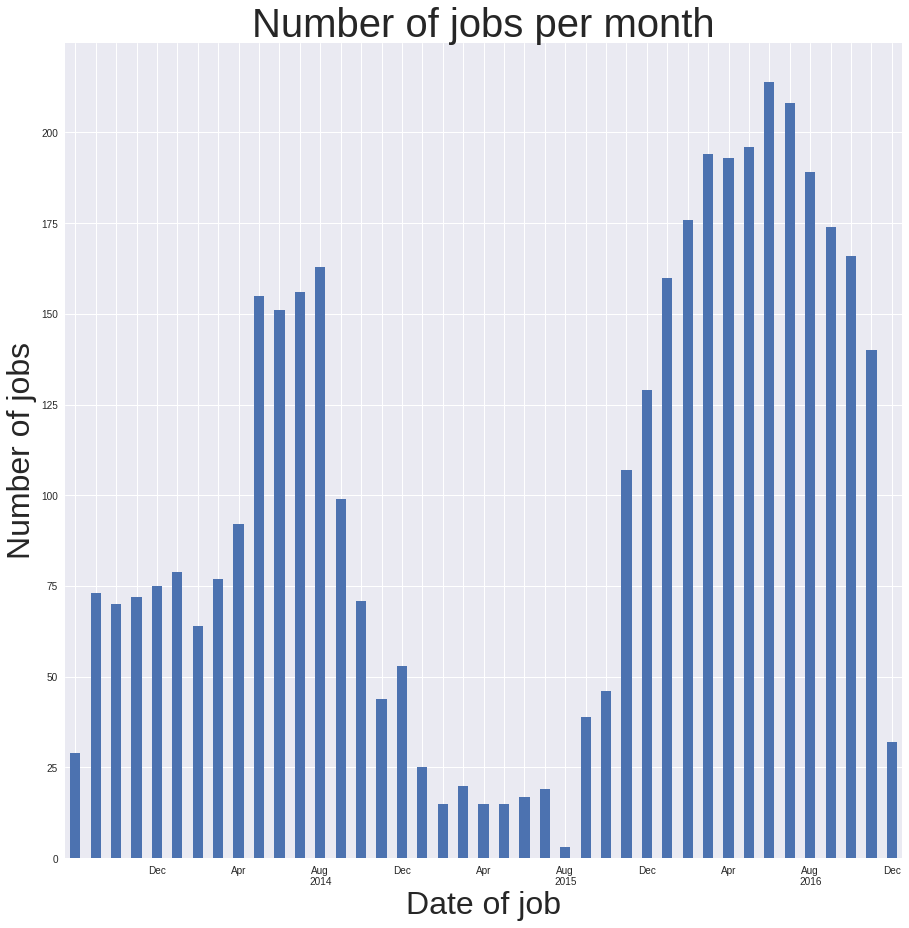

In [18]:
# Create a histogram of the start dates
df = dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count()
ax = df.plot(kind="bar", rot=0, figsize=(15,15));


plt.xlabel('Date of job', fontsize=32);
plt.ylabel('Number of jobs', fontsize=32);
plt.title('Number of jobs per month', fontsize=40);

# This just customizes our ticker so that the labels aren't squished.
ticklabels = ['']*len(df.index) # Create a list of tick labels the same size as our index
monthLabel = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Every 4th tick shows the month and day
ticklabels[::4] = [monthLabel[item[1]-1] for item in df.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = ['{}\n{}'.format(monthLabel[item[1]-1], item[0]) for item in df.index[::12]]
# Get rid of first tick
ticklabels[0] = ''
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#plt.gcf().autofmt_xdate()

# There's definitely a variation in the jobs over time. 

Not as many moving jobs during the winter period. 2015 was a very bad year. Summer better than winter. September through November is worst for jobs. Although in 2016, there was a spike in jobs in 

## Cancelled jobs

Cancelled jobs can be a problem for the business. However, it looks like only 4% of the jobs were listed as cancelled. We may be able to look further into the _summary_ field or _date_ field to learn more about why jobs were cancelled.

In [19]:
print('There were {} cancelled jobs out of {} total jobs({:.2f}%)'.format(sum(dfJobs['CANCELLED']), 
                                                                          len(dfJobs['CANCELLED']), 
                                                                100.0*sum(dfJobs['CANCELLED'])/len(dfJobs['CANCELLED'])))

There were 173 cancelled jobs out of 4015 total jobs(4.31%)


In [20]:
dfJobs

,DTSTART,DTEND,RRULE,DTSTAMP,UID,CREATED,DESCRIPTION,ORIGIN,ORIGIN TYPE,ORIGIN ZIP CODE,...,RATE,CUSTOMER NAME,CUSTOMER PHONE,CUSTOMER EMAIL,LAST MODIFIED,LOCATION,SEQUENCE,SUMMARY,CANCELLED,TRANSP
0,2013-08-17 15:00:00,2013-08-17 16:00:00,None,2016-11-29 12:31:58,ADD8F2DD-BFEC-4BF8-935F-D8AC24FCBBA8,2013-08-16 00:08:29,7 hours =$975\n15%=$146.25\nJllano@sdsp.net,None,None,None,...,NaN,None,None,Jllano@sdsp.net,2013-08-18 17:53:08,972 broadway 91911 building bihind 970 to 2811...,0,$130/hr $65 gas John Llano 619-520-3564\; 619-...,False,OPAQUE
1,2013-08-18 22:00:00,2013-08-18 23:00:00,None,2016-11-29 12:31:58,5BB18929-7974-4C88-9C53-95588D841D7D,2013-08-18 17:35:50,4:15 $306\n15%- $46.00,None,None,None,...,NaN,None,None,None,2013-08-19 20:27:06,7864 avenida navidad San Diego 92122 #195 to 8...,0,$65 $30 kar khe 832-466-5649 858-663-5613,False,OPAQUE
2,2013-08-18 20:30:00,2013-08-18 21:30:00,None,2016-11-29 12:31:58,97vcl68nn3potk63j78ds7vs54@google.com,2013-08-19 20:31:03,,None,None,None,...,NaN,None,None,None,2013-08-19 20:31:03,,0,Send 146.25+46= 192.25,False,OPAQUE
3,2013-08-19 19:00:00,2013-08-19 20:00:00,None,2016-11-29 12:31:58,B7461062-4494-4A2D-8E78-5538A8E980DD,2013-08-15 20:51:30,Ao.dawson88@gmail.com\nPark on beech st \n4 ho...,None,None,None,...,NaN,None,None,Ao.dawson88@gmail.com,2013-08-26 00:35:09,1455 kertner blvd apt526 92101 to 801 ash st a...,1,$65 $30 Alex Dawson 928-301-3402,False,OPAQUE
4,2013-08-20 15:00:00,2013-08-20 16:00:00,None,2016-11-29 12:31:58,uitttdtrjts4vermju9k0vtf5c@google.com,2013-08-18 00:58:34,"$15 wardrobes\n3 hours\, 3wardrobes \n15% $37.05",None,None,None,...,NaN,None,None,None,2013-08-26 00:39:28,707 10-th ave san diego ca 92101 to storage se...,2,Andrew Garry 860-705-4143 $65 $20 5% off,False,OPAQUE
5,2013-08-20 15:00:00,2013-08-20 16:00:00,None,2016-11-29 12:31:58,2i941ljktu1raatvg1dlgvk1h0@google.com,2013-08-19 18:57:51,Mazi7474@yahoo.com\n19.5 hrs ( 5% off)\n15%$20...,None,None,None,...,NaN,None,None,Mazi7474@yahoo.com,2013-08-26 00:40:42,3435 capri way unit 1 oceanside ca 92056 to 21...,1,Mahsa Ziadloo 760-846-5094 760-846-5097 $140 $65,False,OPAQUE
6,2013-08-20 21:00:00,2013-08-20 22:00:00,None,2016-11-29 12:31:58,222F6FB4-22EB-4FA2-890D-F661709D98D2,2013-08-19 21:16:00,3 hours\n15%$33.75,None,None,None,...,NaN,None,None,None,2013-08-26 00:41:21,#224 11549 Windcrest lane 92128 to storage.,0,Alene Mcbride 858-568-3848 $65 $30,False,OPAQUE
7,2013-08-21 17:00:00,2013-08-21 18:00:00,None,2016-11-29 12:31:58,btfvh5trm4924q1thqdedlaslg@google.com,2013-08-22 01:42:46,3 hours \n$31.5,None,None,None,...,NaN,None,None,None,2013-08-26 00:42:13,6586 embrosia dr #5405 san diego 92124,1,Daby Davis 702-715-5801 $65 $15,False,OPAQUE
8,2013-08-23 14:00:00,2013-08-23 15:00:00,None,2016-11-29 12:31:58,0g22cflo9jscgjlkedoeca7jd4@google.com,2013-08-23 01:47:30,mosb_33@hotmail.com\n3 hours\n$33.75,None,None,None,...,NaN,None,None,mosb_33@hotmail.com,2013-08-26 00:42:50,6699 beadnell apt 241 san diego 92117 to 910 d...,0,Nouf Barasayn 858-717-3392 $65 $30,False,OPAQUE
9,2013-08-23 17:12:00,2013-08-23 18:12:00,None,2016-11-29 12:31:58,5FF5E7A1-4FD4-4B93-8107-C2033BC6D12E,2013-08-23 16:52:58,4 hr\n$44.25,None,None,None,...,NaN,None,None,None,2013-08-26 00:44:18,Carlos Mantoya 832-712-4685 $65 $35,0,Carlos Mantoya 832-712-4685 $65 $35,False,OPAQUE


In [21]:
dfJobs.ix[4009]

DTSTART                                               2016-12-01 22:00:00
DTEND                                                 2016-12-02 06:00:00
RRULE                                                                None
DTSTAMP                                               2016-11-29 12:31:59
UID                                 mseq63sf79542ehq1isoq6mg94@google.com
CREATED                                               2016-11-29 00:57:30
DESCRIPTION             December 1\, 2016 2:00pm PST\nCalendar: Vector...
ORIGIN                     2870 Fifth Ave. Suite 107 San Diego\, Ca 92103
ORIGIN TYPE                                                        Office
ORIGIN ZIP CODE                                                     92103
DESTINATION                                                          None
DESTINATION TYPE                                                     None
DESTINATION ZIP CODE                                                 None
SIZE                                  

In [22]:
dfJobs['DESCRIPTION'].ix[4009].split('\\n')

['December 1\\, 2016 2:00pm PST',
 'Calendar: Vector Moving and Storage',
 "Client's time zone: America/Los_Angeles (appointment is December 1\\, 2016 2:00pm PST)",
 'Name: Shawn Fisher',
 'Phone: (619) 228-4293',
 'E-mail: sfisher228@gmail.com',
 '',
 'Details for a move.',
 '============',
 'Rate and Fees: $125/hour cash $135/hour card',
 '',
 'Crew Size: 3 movers and a truck',
 '',
 'Is packing service needed?  (small items packing into the boxes): Packing is not needed.',
 '',
 'Moving appliances (what exactly)?: ',
 '',
 'Pick up Address: 2870 Fifth Ave. Suite 107 San Diego\\, Ca 92103',
 '',
 'Pick up Address Type: Office',
 '',
 'Pick Up Address Size and Sq ft: 1\\,600sq. ft. ',
 '',
 'Amount of Household Goods to Move: Entire place',
 '',
 'Pick Up Address Access: Ground Floor Access',
 '',
 'Walking Distance from the place of truck parking to the front door at the Pick Up Address: 0-50 ft',
 '',
 'Drop Off Address: 1450 Frazee Road. San Diego. 92108',
 '',
 'Drop off  Address 

In [23]:
dfJobs.to_csv('VectorMovingJobs.csv')